In [46]:
import rasterio as rio
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
from matplotlib.colors import Normalize
import numpy as np
import numpy.matlib
from scipy import interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as st
import scipy
import os, sys, pickle, gzip
import datetime
import geopy.distance
import xarray as xr
import pandas as pd
import rasterio
import geopandas as gpd
import shapely.geometry
import shapely.ops
import xesmf as xe
import cartopy
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
import itertools
import random
import metpy
from metpy.plots import USCOUNTIES

import warnings
warnings.filterwarnings('ignore')

In [47]:
run ../util/setupConsole_su

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 432x288 with 0 Axes>

In [48]:
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirEra5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirHeatData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/2021-heat'
dirAg6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'

In [49]:
era5_max_deciles = xr.open_dataset('%s/era5_tw_max_deciles.nc'%dirHeatData)
lat = era5_max_deciles.latitude.values
lon = era5_max_deciles.longitude.values

In [50]:
sacksMaizeNc = xr.open_dataset('%s/sacks/Maize.crop.calendar.fill.nc'%dirAgData)
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

sacksLat = np.linspace(90, -90, 360)
sacksLon = np.linspace(0, 360, 720)

# regrid sacks data
regridMesh = xr.Dataset({'lat': (['lat'], lat),
                         'lon': (['lon'], lon),})

regridder_start = xe.Regridder(xr.DataArray(data=sacksStart, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)
regridder_end = xe.Regridder(xr.DataArray(data=sacksEnd, dims=['lat', 'lon'], coords={'lat':sacksLat, 'lon':sacksLon}), regridMesh, 'bilinear', reuse_weights=True)

sacksStart_regrid = regridder_start(sacksStart)
sacksEnd_regrid = regridder_end(sacksEnd)

Reuse existing file: bilinear_360x720_721x1440.nc
Reuse existing file: bilinear_360x720_721x1440.nc


In [51]:
land_sea_mask = xr.open_dataset('%s/land-sea-mask.nc'%dirEra5)
land_sea_mask.load()
N_gridcells = np.where((land_sea_mask.lsm[0,:,:].values.reshape([lat.size*lon.size]))>0)[0].size

In [52]:
with open('%s/cropped_area/crop_land_regrid_era5.dat'%(dirAg6), 'rb') as f:
    crop_ha_regrid = pickle.load(f)
    crop_ha_regrid_1d = crop_ha_regrid.reshape([crop_ha_regrid.size, 1])

In [79]:
yearRange = np.arange(1981, 2022)

In [80]:
weekly_tx = np.full([len(yearRange), 53, lat.size, lon.size], np.nan)
weekly_tw = np.full([len(yearRange), 53, lat.size, lon.size], np.nan)


for y_ind, y in enumerate(yearRange):
    print('loading %d'%y)
    tx = xr.open_dataset('weekly_tx_tw/tx_weekly_%d.nc'%(y))
    tx.load()
    
    tw = xr.open_dataset('weekly_tx_tw/tw_weekly_%d.nc'%(y))
    tw.load()
    
    weekly_tx[y_ind, :, :, :] = tx.mx2t.values
    weekly_tw[y_ind, :, :, :] = tw.tw.values

loading 1981
loading 1982
loading 1983
loading 1984
loading 1985
loading 1986
loading 1987
loading 1988
loading 1989
loading 1990
loading 1991
loading 1992
loading 1993
loading 1994
loading 1995
loading 1996
loading 1997
loading 1998
loading 1999
loading 2000
loading 2001
loading 2002
loading 2003
loading 2004
loading 2005
loading 2006
loading 2007
loading 2008
loading 2009
loading 2010
loading 2011
loading 2012
loading 2013
loading 2014
loading 2015
loading 2016
loading 2017
loading 2018
loading 2019
loading 2020
loading 2021


In [72]:
lat_inds = np.where((lat<=45) & (lat >= 35))[0]
lon_inds = np.where((lon<280) & (lon > 250))[0]

In [73]:
lon_inds

array([1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010, 1011,
       1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021, 1022,
       1023, 1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033,
       1034, 1035, 1036, 1037, 1038, 1039, 1040, 1041, 1042, 1043, 1044,
       1045, 1046, 1047, 1048, 1049, 1050, 1051, 1052, 1053, 1054, 1055,
       1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063, 1064, 1065, 1066,
       1067, 1068, 1069, 1070, 1071, 1072, 1073, 1074, 1075, 1076, 1077,
       1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088,
       1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099,
       1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110,
       1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119])

In [74]:
weekly_tx_trend = np.full([53], np.nan)
weekly_tw_trend = np.full([53], np.nan)

n = 0

for w in np.arange(weekly_tx.shape[1]):
    ts_tx = np.nanmean(np.nanmean(weekly_tx[:, w, lat_inds, :][:, :, lon_inds], axis=2), axis=1)
    ts_tw = np.nanmean(np.nanmean(weekly_tw[:, w, lat_inds, :][:, :, lon_inds], axis=2), axis=1)

    nn = np.where((~np.isnan(ts_tx)))[0]
    X = sm.add_constant(np.arange(ts_tx[nn].size))
    mdl_tx = sm.OLS(ts_tx[nn], X).fit()
    weekly_tx_trend[w] = mdl_tx.params[1]

    nn = np.where((~np.isnan(ts_tw)))[0]
    X = sm.add_constant(np.arange(ts_tw[nn].size))
    mdl_tw = sm.OLS(ts_tw[nn], X).fit()
    weekly_tw_trend[w] = mdl_tw.params[1]


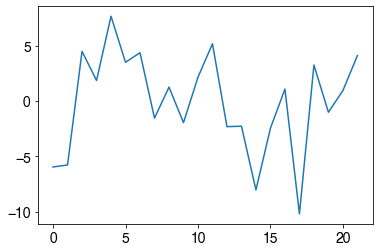

In [75]:
plt.plot(ts_tw)

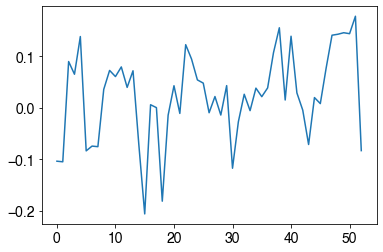

In [76]:
plt.plot(weekly_tx_trend)

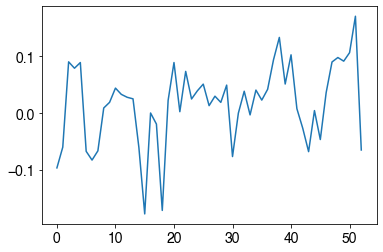

In [77]:
plt.plot(weekly_tw_trend)

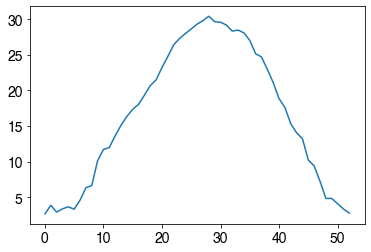

In [78]:
plt.plot(np.nanmean(np.nanmean(np.nanmean(weekly_tx[:,:,lat_inds, :][:,:,:,lon_inds], axis=3), axis=2), axis=0))